# Market Basket Analysis (MBA) 
In this notebook, I want to perform a simple MBA to learn more about how to apply frequent pattern mining to shop data. I am using a dataset that is publicly available on kaggle.com and I test the Apriori and the FP Growth algorithm, which is slightly more complex under the hood.  

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #visualisation
sns.set(color_codes=True)
import scipy.stats as stats

from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules #for apriori mba

In [2]:
# dataset retrieved from :https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis
df = pd.read_xlsx('data/data.csv')

## Start Exploratory Data Analysis (EDA)

Let's have a first look at the dataset. For our purpose of a quick and simple Market Basket Analysis, the most important data will be the InvoiceNo and Description columns as they contain the data about which products have been bought together. 

In more detailed analysis, it would also be interesting to incorporate the CustomerID in order to explore which items get purchased by the same individual, irrespective of the date at which the individual items have been purchased. 

In [3]:
#look at head of dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape #dataset has 8 columns and ca. 542,000 rows

(541909, 8)

### Check for datatypes and missing data
The columns "Description" and "CustomerID" seem to have some missing data. The datatypes of InvoiceNo, StockCode and InvoiceDate also seem to be not correct as one would expect numeric data (int or float) instead of object datatype.

In [5]:
#look at datatypes in the columns. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
#check for missing data in the dataset
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
#look at percentages of missing data
print(f"Missing Descriptions: {round(df.isnull().sum()['Description'] / len(df) * 100, 2)}%")
print(f"Missing CustomerIDs: {round(df.isnull().sum()['CustomerID'] / len(df) * 100, 2)}%")

Missing Descriptions: 0.27%
Missing CustomerIDs: 24.93%


### Look at descriptions
Let's have a look at the descriptions and their occurrences. The data contains 4223 unique product descriptions. The most purchased item seems to be the "WHITE HANGING HEART T-LIGHT HOLDER" with 2369 occurrences. The mean of 128 and the median of 57 occurrences imply a rather long tail of products that are not bought very frequently. 

Looking at the least purchased items, we can find some weird looking descriptions like "wet", "wrong barcode" or "broken". These do not seem to be proper product names but still contain some value as they could show us if there for example are products that are labeled as wet more often than others. 

In [8]:
df.Description.value_counts(dropna=False).describe()

count    4224.000000
mean      128.292850
std       196.075713
min         1.000000
25%        11.000000
50%        57.000000
75%       161.250000
max      2369.000000
Name: Description, dtype: float64

We can visualize the long tail by plotting how often a description is included in the dataset. Few products are being bought often and many products are being bought not so often

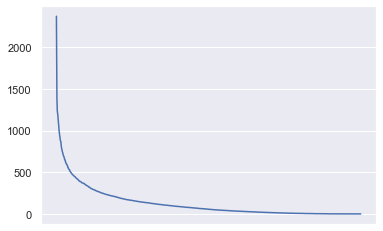

In [9]:
plt.plot(df.Description.value_counts().index, df.Description.value_counts())
plt.xticks([]) #hide x axis lables
plt.show()

The most common descriptions seem to relate to real products

In [10]:
#look at top 50 descriptions
df.Description.value_counts()[:50]

WHITE HANGING HEART T-LIGHT HOLDER     2369
REGENCY CAKESTAND 3 TIER               2200
JUMBO BAG RED RETROSPOT                2159
PARTY BUNTING                          1727
LUNCH BAG RED RETROSPOT                1638
ASSORTED COLOUR BIRD ORNAMENT          1501
SET OF 3 CAKE TINS PANTRY DESIGN       1473
PACK OF 72 RETROSPOT CAKE CASES        1385
LUNCH BAG  BLACK SKULL.                1350
NATURAL SLATE HEART CHALKBOARD         1280
POSTAGE                                1252
JUMBO BAG PINK POLKADOT                1251
HEART OF WICKER SMALL                  1237
JAM MAKING SET WITH JARS               1229
JUMBO STORAGE BAG SUKI                 1214
PAPER CHAIN KIT 50'S CHRISTMAS         1210
JUMBO SHOPPER VINTAGE RED PAISLEY      1202
LUNCH BAG CARS BLUE                    1197
LUNCH BAG SPACEBOY DESIGN              1192
JAM MAKING SET PRINTED                 1182
RECIPE BOX PANTRY YELLOW DESIGN        1180
SPOTTY BUNTING                         1172
LUNCH BAG SUKI DESIGN           

Descriptions that rarely occur seem to not always be directly referencing a product but also to sometimes describe a process that a product has been involved in. 

In [11]:
#look at bottom 50 descriptions
df.Description.value_counts()[-50:]

ETCHED GLASS STAR TREE DECORATION      1
? sold as sets?                        1
4 GOLD FLOCK CHRISTMAS BALLS           1
PINK PAINTED KASHMIRI CHAIR            1
historic computer difference?....se    1
came coded as 20713                    1
WRAP  PINK FLOCK                       1
mouldy, thrown away.                   1
PACK 4 FLOWER/BUTTERFLY PATCHES        1
wrongly sold sets                      1
LASER CUT MULTI STRAND NECKLACE        1
PINK ACRYLIC JEWEL SNOWFLAKE           1
PINK FLOCK PHOTO FRAME                 1
allocate stock for dotcom orders ta    1
PINK BAROQUE FLOCK CANDLE HOLDER       1
FBA                                    1
PURPLE ANEMONE ARTIFICIAL FLOWER       1
GLASS BEAD HOOP NECKLACE BLACK         1
???                                    1
BLACK CHRISTMAS FLOCK DROPLET          1
incorrectly put back into stock        1
SET 10 CARDS SNOWY ROBIN 17099         1
Had been put aside.                    1
GLASS BELL JAR SMALL                   1
BEADED LOVE HEAR

In the following, we check the description for some common keywords to learn more about the damage and error reports that are contained in some of the descriptions

In [12]:
#function to count occurrences in a list --> useful when working with list comprehensions
def list_val_count(values):
    val_dict = {}
    for val in values:
        if not val in val_dict:
            val_dict[val] = 1
        else:
            val_dict[val] += 1
    
    u = pd.DataFrame(data={'Count':list(val_dict.values())}, index= list(val_dict.keys()) )
    
    #return sorted data
    return u.sort_values('Count', ascending=False)

In [13]:
list_val_count([d for d in df.Description if "broke" in str(d).lower()])

,Count
broken,1


In [14]:
list_val_count([d for d in df.Description if "damage" in str(d).lower()])

,Count
damages,45
damaged,43
Damaged,14
wet damaged,5
damages?,5
damages wax,2
water damaged,1
Damages,1
Damages/samples,1
water damage,1


In [15]:
#check which descriptions are associated with "wet"
list_val_count([d for d in df.Description if "wet" in str(d).lower()])

,Count
wet damaged,5
wet pallet,3
wet/rusty,2
wet rusty,2
WET/MOULDY,1
Wet pallet-thrown away,1
wet?,1
wet,1
wet boxes,1


In [16]:
list_val_count([d for d in df.Description if "wrong" in str(d).lower()])

,Count
wrongly coded 20713,2
wrongly sold sets,1
wrongly marked carton 22804,1
Wrongly mrked had 85123a in box,1
wrongly marked,1
wrongly coded 23343,1
20713 wrongly marked,1
wrongly marked 23343,1
wrongly coded-23343,1
wrongly sold as sets,1


In [17]:
list_val_count([d for d in df.Description if "found" in str(d).lower()])

,Count
found,25
Found,8
found some more on shelf,1
FOUND,1
found box,1
Found in w/hse,1
Found by jackie,1


In [18]:
list_val_count([d for d in df.Description if "sold " in str(d).lower()])

,Count
sold as set on dotcom,20
sold as 1,2
wrongly sold as sets,1
sold as 22467,1
Sold as 1 on dotcom,1
sold as set by dotcom,1
sold as set on dotcom and amazon,1
sold as set/6 by dotcom,1
sold in set?,1
Amazon sold sets,1


In [19]:
list_val_count([d for d in df.Description if "?" in str(d).lower()])

,Count
?,47
??,7
damages?,5
???missing,2
?missing,2
?sold as sets?,1
missing?,1
???,1
lost??,1
wet?,1


The description column also contains many occurrences of "POSTAGE". This makes sense but is not really a product that we are interested in. Thus, we might want to delete rows containing this description in the data cleaning process

In [20]:
df[df.Description == "POSTAGE"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,12/1/2010 8:45,18.0,12583.0,France
386,536403,POST,POSTAGE,1,12/1/2010 11:27,15.0,12791.0,Netherlands
1123,536527,POST,POSTAGE,1,12/1/2010 13:04,18.0,12662.0,Germany
5073,536840,POST,POSTAGE,1,12/2/2010 18:27,18.0,12738.0,Germany
5258,536852,POST,POSTAGE,1,12/3/2010 9:51,18.0,12686.0,France
...,...,...,...,...,...,...,...,...
541198,581493,POST,POSTAGE,1,12/9/2011 10:10,15.0,12423.0,Belgium
541216,581494,POST,POSTAGE,2,12/9/2011 10:13,18.0,12518.0,Germany
541730,581570,POST,POSTAGE,1,12/9/2011 11:59,18.0,12662.0,Germany
541767,581574,POST,POSTAGE,2,12/9/2011 12:09,18.0,12526.0,Germany


### Look at Invoices
There are 24446 invoices with a median of 11 occurences (products?) per invoice. One invoice occurs more than 1000 times in the dataset, which implies that it is associated with more than 1000 different products.

Plotting the value counts shows that most invoice numbers occur less than 100 times in the dataset. 

In [21]:
df.InvoiceNo.value_counts().describe()

count    25900.000000
mean        20.923127
std         43.031334
min          1.000000
25%          2.000000
50%         10.000000
75%         23.000000
max       1114.000000
Name: InvoiceNo, dtype: float64

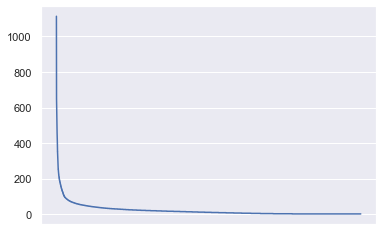

In [22]:
plt.plot(df.InvoiceNo.value_counts().index, df.InvoiceNo.value_counts())
plt.xticks([]) #hide x axis lables
plt.show()

Looking at the invoice numbers that occur least often in the data, we can see that some of them contain letters as well as numbers. This is important knowledge for the later handling of this data!

In [23]:
#look at top 50 invoices
df.InvoiceNo.value_counts()[-50:]

551323     1
C539956    1
581206     1
562812     1
572686     1
544807     1
C554544    1
C560550    1
541114     1
560717     1
C552936    1
571198     1
576877     1
C559651    1
540256     1
544342     1
551424     1
C564997    1
C574912    1
567063     1
537870     1
545567     1
C538164    1
C556265    1
577494     1
556287     1
578629     1
558453     1
576415     1
C550026    1
C561590    1
C566966    1
548402     1
567694     1
557756     1
C556638    1
C578090    1
542154     1
581209     1
569392     1
544154     1
547916     1
580546     1
551572     1
C545511    1
549004     1
578268     1
543257     1
C575872    1
555104     1
Name: InvoiceNo, dtype: int64

### Look at Quantity
When looking at the quantity column, we can see that some purchases are associated with negative quantities. These might be cancellations of orders. As we are only interested in which products get purchased together and not which get cancelled, we might want to delete rows the roughly 10.000 rows containing these negative quantities.

In [24]:
df.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [25]:
df.loc[(df.Quantity < 0)][['StockCode','Description','Quantity','UnitPrice']]

,StockCode,Description,Quantity,UnitPrice
141,D,Discount,-1,27.50
154,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65
235,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65
236,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29
237,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29
...,...,...,...,...
540449,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83
541541,M,Manual,-1,224.69
541715,21258,VICTORIAN SEWING BOX LARGE,-5,10.95
541716,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,1.25


## Data Cleaning

Let's clean up some of the weird data that we have encountered so far. Under normal circumstances, the EDA would be more extensive but for the sake of doing a quick market basket analysis, we will skip other exploratory steps for now.

We start by dropping unused columns. The CustomerID contains some null values that could lead to us dropping more data than we want when using the dropna command. Thus, we store a copy of our dataframe with CustomerID for possible later use and drop the column in our df for now. It might be useful when trying to figure out what products different types of consumer are interested in, irrespective of the individual transactions that the products are contained in. 

Then, we drop all rows that contain null values. This will only be the comparatively few rows with missing product descriptions. 

In [26]:
#store a copy of the untouched dataframe for possible later use
df_with_customers = df.copy()

#drop column with customerID 
df.drop("CustomerID", axis=1, inplace=True)

#drop all rows that contain null values -> this will be the 1454 missing descriptions
df.dropna(inplace=True)

#change invoice dates into datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

#transform all descriptions and invoice ids into string format and delete trailing and leading spaces
df["Description"] = df["Description"].str.strip()
df["InvoiceNo"] = df["InvoiceNo"].str.strip()

#drop rows that contain negative quantities
df = df.loc[(df.Quantity >= 0) & (df.Description != "POSTAGE")]

Let's start relabelling some of the error reports that are contained in the description data. When similar errors have the same label, our algorithm might be able to pick up which products are related to errors. 

In [27]:
#replace error description with standardized label
desc = list(df.Description)
for i in range(len(desc)):
    if 'broke' in desc[i] or 'damage' in desc[i] or 'wet' in desc[i]:
        desc[i] = 'damage'
    elif 'found' in desc[i]:
        desc[i] = 'found'
    elif 'wrong' in desc[i]:
        desc[i] = 'wrong'
    elif '?' in desc[i]:
        desc[i] = "?"
        
#change column Description for new labels
df.drop("Description", axis=1, inplace= True)
df["Description"] = desc

## Market Basket Analysis

**Support** = number of times a product is part of a transaction 
<br><br>
**Confidence** = explains how likely it is that product y is bought under the condition that product x is in the basket as well
<br><br>
**Lift** = says how likely item Y is purchased when item X is purchased, while controlling for how popular item Y is. Lift > 1 implies negative association, Lift == 1 implies no association and Lift > 1 implies that Y is likely purchased if X is purchased as well. This metric is important in case that X and Y are both items that are bought very frequently but that are not neccesseraly related to each other. For example, people often buy bread and water either individually or alone. This might lead to a high confidence for a combination of both products that is purely the result of both products being bought often but not being associated with each other. It would make more sense to show a bread customer an advertising for peanutbutter instead of water.

### Apriori Algorithm

I want to at first try the Apriori Algorithm to identify associations among products in individual purchases. 
The documentation for the mlxtend apriori algorithm can be found here: http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

In [28]:
all_countries = df.groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
all_countries.head()

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,mailout,michel oops,on cargo order,rcvd be air temp fix for dotcom sit,returned,taig adjust,test,to push order througha s stock was,website fixed,wrong
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#check out available country codes in the data
df.Country.unique()

#create dataframe for countries of interest
basket_GER = df[df['Country'] =="Germany"].groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_USA = df[df['Country'] =="USA"].groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_FRA = df[df['Country'] =="France"].groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_UK = df[df['Country'] =="United Kingdom"].groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [30]:
#hot encode the data as the apriori algorithm only needs to know if a product is contained in a transaction (1) or not (0)
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

all_countries = all_countries.applymap(hot_encode)

In [40]:
#get items and itemsets that are contained in a minimum fraction of transactions defined by min_support variable
frequent_itemsets  = apriori(all_countries, min_support = 0.03, use_colnames = True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.sort_values(by=['length','support'], ascending=[False, False])
rules = association_rules(frequent_itemsets, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['lift', 'confidence'], ascending =[False, False])
rules.head(20).iloc[: , :7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038185,0.050598,0.031555,0.826371,16.332017
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.050598,0.038185,0.031555,0.623645,16.332017
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.050598,0.053141,0.038285,0.756650,14.238653
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.053141,0.050598,0.038285,0.720450,14.238653
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.048853,0.052393,0.031904,0.653061,12.464708
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.052393,0.048853,0.031904,0.608944,12.464708
15,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.054337,0.077966,0.030209,0.555963,7.130834
14,(LUNCH BAG RED RETROSPOT),(LUNCH BAG PINK POLKADOT),0.077966,0.054337,0.030209,0.387468,7.130834
7,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.060718,0.104287,0.041127,0.677340,6.494951
6,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.104287,0.060718,0.041127,0.394359,6.494951


#### Associations in purchases from Germany
The apriori algorithm produces pairs of products that make perfectly sense. The highest lift can be observed for products that logically fit together, such as cups and bowls with the same images on them (idx 138) or cups and matching plates (idx 134, idx 101). 

Interestingly, among the products that are likely to be purchased together, there are not only products that complement each other (like cup and bowl) but also those that could replace one another (like pink jar and green jar). This might be because the shop from which this data is taken also sells to wholesalers and not just to consumers.

In [53]:
basket_GER = basket_GER.applymap(hot_encode)
frequent_itemsets_GER  = apriori(basket_GER, min_support = 0.03, use_colnames = True)
frequent_itemsets_GER['length'] = frequent_itemsets_GER['itemsets'].apply(lambda x: len(x))
rules_GER = association_rules(frequent_itemsets_GER, metric ="lift", min_threshold = 1)
rules_GER = rules_GER.sort_values(['lift', 'confidence'], ascending =[False, False])
rules_GER.head(20).iloc[: , :7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
138,(SPACEBOY CHILDRENS BOWL),(SPACEBOY CHILDRENS CUP),0.042316,0.044543,0.037862,0.894737,20.086842
139,(SPACEBOY CHILDRENS CUP),(SPACEBOY CHILDRENS BOWL),0.044543,0.042316,0.037862,0.850000,20.086842
19,(CHILDRENS CUTLERY DOLLY GIRL),(CHILDRENS CUTLERY SPACEBOY),0.051225,0.048998,0.040089,0.782609,15.972332
18,(CHILDRENS CUTLERY SPACEBOY),(CHILDRENS CUTLERY DOLLY GIRL),0.048998,0.051225,0.040089,0.818182,15.972332
134,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.053452,0.057906,0.046771,0.875000,15.110577
135,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.057906,0.053452,0.046771,0.807692,15.110577
27,(JAM JAR WITH PINK LID),(JAM JAR WITH GREEN LID),0.064588,0.035635,0.033408,0.517241,14.515086
26,(JAM JAR WITH GREEN LID),(JAM JAR WITH PINK LID),0.035635,0.064588,0.033408,0.937500,14.515086
20,(COFFEE MUG PEARS DESIGN),(COFFEE MUG APPLES DESIGN),0.040089,0.062361,0.035635,0.888889,14.253968
21,(COFFEE MUG APPLES DESIGN),(COFFEE MUG PEARS DESIGN),0.062361,0.040089,0.035635,0.571429,14.253968


#### Associations in purchases from France

Compared to the German product associations, it is interesting to see that the product combinaitons with the highest lift and confidence in France are almost exclusively pairs of disposable dinnerware like paper cups and paper plates. This could be explained by the French tradition of making picknicks with friends and family.


In [49]:
basket_FRA = basket_FRA.applymap(hot_encode)
frequent_itemsets_FRA  = apriori(basket_FRA, min_support = 0.1, use_colnames = True)
frequent_itemsets_FRA['length'] = frequent_itemsets_FRA['itemsets'].apply(lambda x: len(x))
rules_FRA = association_rules(frequent_itemsets_FRA, metric ="lift", min_threshold = 1)
rules_FRA = rules_FRA.sort_values(['lift', 'confidence'], ascending =[False, False])
rules_FRA.head(20).iloc[: , :7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
10,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.103359,0.129199,0.100775,0.975000,7.546500
15,(SET/6 RED SPOTTY PAPER PLATES),"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",0.129199,0.103359,0.100775,0.780000,7.546500
12,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER CUPS),0.103359,0.139535,0.100775,0.975000,6.987500
13,(SET/6 RED SPOTTY PAPER CUPS),"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",0.139535,0.103359,0.100775,0.722222,6.987500
9,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.129199,0.139535,0.124031,0.960000,6.880000
8,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.139535,0.129199,0.124031,0.888889,6.880000
11,"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.124031,0.134367,0.100775,0.812500,6.046875
14,(SET/20 RED RETROSPOT PAPER NAPKINS),"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",0.134367,0.124031,0.100775,0.750000,6.046875
7,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),0.129199,0.134367,0.103359,0.800000,5.953846
6,(SET/20 RED RETROSPOT PAPER NAPKINS),(SET/6 RED SPOTTY PAPER PLATES),0.134367,0.129199,0.103359,0.769231,5.953846


### FP Growth Algorithm

Comparing the top results of the Apriori and the FP Growth Algorithm, we can see that they yield identical results even though the inices in the resulting dataframes are different. 

In [61]:
frequent_itemsets = fpgrowth(all_countries, min_support=0.03, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.sort_values(by=['length','support'], ascending=[False, False])
rules = association_rules(frequent_itemsets, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['lift', 'confidence'], ascending =[False, False])
rules.head(20).iloc[: , :7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
14,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038185,0.050598,0.031555,0.826371,16.332017
15,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.050598,0.038185,0.031555,0.623645,16.332017
13,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.050598,0.053141,0.038285,0.756650,14.238653
12,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.053141,0.050598,0.038285,0.720450,14.238653
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.048853,0.052393,0.031904,0.653061,12.464708
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.052393,0.048853,0.031904,0.608944,12.464708
9,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.054337,0.077966,0.030209,0.555963,7.130834
8,(LUNCH BAG RED RETROSPOT),(LUNCH BAG PINK POLKADOT),0.077966,0.054337,0.030209,0.387468,7.130834
3,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.060718,0.104287,0.041127,0.677340,6.494951
2,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.104287,0.060718,0.041127,0.394359,6.494951


### Apriori vs. FP Growth Speed Comparison

Comparing the average duration for the Apriori and the FP Growth algorith shows the computational advantage of the tree-based FP Growth algorithm that does not have to scan the database over and over again. In our example, it is on average 20% faster than the Apriori alternative.

In [66]:
%timeit -n 50 -r 10 fpgrowth(basket_GER, min_support=0.03, use_colnames=True)

82.4 ms ± 17 ms per loop (mean ± std. dev. of 10 runs, 50 loops each)


In [67]:
%timeit -n 50 -r 10 apriori(basket_GER, min_support=0.03, use_colnames=True)

99.8 ms ± 11.7 ms per loop (mean ± std. dev. of 10 runs, 50 loops each)
